# ZombieApocalypse

The general idea is the simulation of a zombie apocalypse as a simple SI (susceptible-infected) on a network topology. This baseline model is than used to explore three different scenarios of social dynamics:

* Escape
* Sentimentality
* Stigmatization

This work relates to and is heavily influenced by the rising tide of zombie models and related research (e.g. [Mathematical Modelling of Zombies](http://www.press.uottawa.ca/mathematical-modelling-of-zombies)).

# Preparations
## Imports

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import random
from nxsim import NetworkSimulation, BaseNetworkAgent, BaseLoggingAgent

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_context('notebook')

## Utility functions

In [2]:
def census_to_df(log, num_trials=1, state_id=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the sum of agents with a given state_id at 
    every time interval of the simulation for every run of the simulation as a pandas
    DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        census = [sum([1 for node_id, state in g.items() 
                       if node_id != 'topology' and state['id'] == state_id]) 
                  for t, g in trial.items()]
        D[name] = census      
    return pd.DataFrame(D)

def edge_count_to_df(log, num_trials=1, state_id=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the edge count for the topology at every
    time interval of the simulation for every run of the simulation as a pandas
    DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        edge_count = [len(trial[key]['topology']) for key in trial]
        D[name] = edge_count
    return pd.DataFrame(D)

def graph_measurses_df(log, func, num_trials=1, state_id=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the provided network measure for the
    topology at every time interval of the simulation for every run of the
    simulation as a pandas DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        measure = [func(nx.Graph(trial[key]['topology'])) 
                   for key in trial]
        D[name] = measure 
    return pd.DataFrame(D)

def friends_to_the_end(log, num_trials=1, dir_path='sim_01'):
    """Reads nxsim log files and returns the number of human friends connected
    to every human at every time interval of the simulation for every run of
    the simulation as a pandas DataFrame object."""
    D = {}
    for i in range(num_trials):
        name = 'Trial ' + str(i)
        trial = log.open_trial_state_history(dir_path=dir_path, 
                                             trial_id=i)
        friends = [np.mean([state['friends'] for node_id, state in g.items() 
                       if node_id != 'topology' and state['id'] == 0]) 
                  for t, g in trial.items()]
        D[name] = friends    
    return pd.DataFrame(D)    

# Topology

As a basic topology a scale free graph is used.

In [11]:
number_of_nodes = 1000
G = nx.scale_free_graph(number_of_nodes).to_undirected()

# Baseline Zombie Model

In the baseline model agents can only have one of two states (0 = susceptible, 1 = infected) and the network topology remains stable. It is therefore only a matter of time for the zombies to overtake the human population. The following code is adapted from the nxsim quickstart [example](https://github.com/kentwait/nxsim#quickstart).

## Defining the agents behavior

In [3]:
class ZombieMassiveOutbreak(BaseNetworkAgent):
    def __init__(self, environment=None, agent_id=0, state=()):
        super().__init__(environment=environment, agent_id=agent_id, state=state)
        
        self.inf_prob = 0.2

    def run(self):
        while True:
            if self.state['id'] == 0:
                self.check_for_infection()
                self.count_friends()
                yield self.env.timeout(1)
            else:
                yield self.env.event()

    def check_for_infection(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.inf_prob:
                self.state['id'] = 1
                print(self.env.now, self.id, '<--', neighbor.id, sep='\t')
                break
                                
    def count_friends(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        self.state['friends'] = len(human_neighbors)

## Executing the simulations

Each simulation runs for 28 ticks and is executed 100 times. The output is captured as a string object in order to keep the notebook readable. The same parameters are used for all three scenarios.

In [ ]:
%%capture capt_log_sim1

# Starting out with a human population
init_states = [{'id': 0, } for _ in range(number_of_nodes)]

# Randomly seeding patient zero
patient_zero = random.randint(0, number_of_nodes)
init_states[patient_zero] = {'id': 1}

# Setting up the simulation
sim = NetworkSimulation(topology=G, states=init_states, agent_type=ZombieMassiveOutbreak, 
                        max_time=28, num_trials=1000, logging_interval=1.0, dir_path='sim_test')

# Running the simulation
sim.run_simulation()

## Plotting the results

Reading and plotting the log files of the simulation runs.

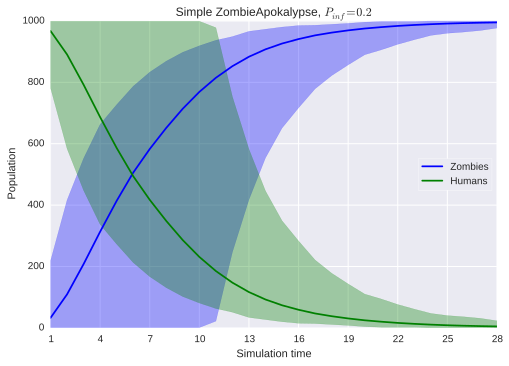

In [5]:
zombies = census_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_01').T
humans = census_to_df(BaseLoggingAgent, 100, 0, dir_path='sim_01').T

plt.plot(zombies.mean(), color='b')
plt.fill_between(zombies.columns, zombies.max(), zombies.min(), color='b', alpha=.33)

plt.plot(humans.mean(), color='g')
plt.fill_between(humans.columns, humans.max(), humans.min(), color='g', alpha=.33)

plt.title('Simple ZombieApokalypse, $P_{inf}=0.2$')
plt.legend(['Zombies', 'Humans'], loc=7, frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Population')
plt.xlabel('Simulation time');

# Escape

The first extended scenario of a zombie apocalypse has the human protagonists fleeing from the undead menace. We call this scenario Escape. Other zombie models sometimes add a “fighting back” strategy, which has the humans taking the fight to the zombies. In zombie lore ,this seems to be almost never a sensible strategy, because in a full-blown zombie apocalypse, the survivors are always completely outnumbered. Under these circumstances, attacking zombies result either in an untimely demise or zombification. In keeping with this perspective, we decided to model the zombie apocalypse as a threat against which there exists no strategy except flight or quarantine procedures. For example, a disease which has a very high lethality and against which there are no countermeasures.

## Defining the agents behavior

In [38]:
class ZombieEscape(BaseNetworkAgent):
    def __init__(self, environment=None, agent_id=0, state=()):
        super().__init__(environment=environment, agent_id=agent_id, state=state)
        
        self.inf_prob = 0.3
        self.run_prob = 0.05

    def run(self):
        while True:
            if self.state['id'] == 0:
                self.run_you_fools()
                self.check_for_infection()
                self.count_friends()
                yield self.env.timeout(1)
            else:
                yield self.env.event()

    def check_for_infection(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.inf_prob:
                self.state['id'] = 1 # zombie
                print('Infection:', self.env.now, self.id, '<--', neighbor.id, sep='\t')
                break
                
    def run_you_fools(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.run_prob:
                self.global_topology.remove_edge(self.id, neighbor.id)
                print('Rejection:', self.env.now, 'Edge:', self.id, neighbor.id, sep='\t')
                
    def count_friends(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        self.state['friends'] = len(human_neighbors)

## Executing the simulation

In [39]:
%%capture capt_log_sim2

# Starting out with a human population
init_states = [{'id': 0, } for _ in range(number_of_nodes)]

# Randomly seeding patient zero
patient_zero = random.randint(0, number_of_nodes)
init_states[patient_zero] = {'id': 1}

# Setting up the simulation
sim = NetworkSimulation(topology=G, states=init_states, agent_type=ZombieEscape, 
                        max_time=28, num_trials=100, logging_interval=1.0, dir_path='sim_02')

# Running the simulation
sim.run_simulation()

## Plotting the results

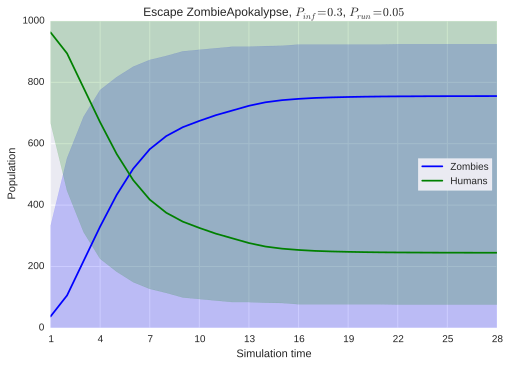

In [6]:
zombies = census_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_02').T
humans = census_to_df(BaseLoggingAgent, 100, 0, dir_path='sim_02').T

## For later comparisons:
mean_escape_zombies = zombies.mean()
mean_escape_humans = humans.mean()

plt.plot(zombies.mean(), color='b')
plt.fill_between(zombies.columns, zombies.max(), zombies.min(), color='b', alpha=.2)

plt.plot(humans.mean(), color='g')
plt.fill_between(humans.columns, humans.max(), humans.min(), color='g', alpha=.2)

plt.title('Escape ZombieApokalypse, $P_{inf} = 0.3$, $P_{run} = 0.05$')
plt.legend(['Zombies', 'Humans'], loc=7, frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Population')
plt.xlabel('Simulation time');

# Sentimentality

This scenario builds on the common zombie trope of having to kill a loved one or member of the group, because they have been bitten and are about to turn. Failure to do so in a timely fashion always results in the death of the human protagonist. It is one of the central themes of the zombie apocalypse to connect humanity’s downfall to our moral choices. In the fallen society of a zombie apocalypse, compassion is weighed against survival. In this scenario, the Escape strategy is made less likely by the emotional bond between a human and a zombie.

## Defining the agents behavior

In [9]:
class ZombieSentimentality(BaseNetworkAgent):
    def __init__(self, environment=None, agent_id=0, state=()):
        super().__init__(environment=environment, agent_id=agent_id, state=state)
        
        self.inf_prob = 0.3
        self.run_prob = 0.05
        self.sent_coef = 0.01

    def run(self):
        while True:
            if self.state['id'] == 0:
                self.check_for_sentimentality()
                self.check_for_infection()
                self.count_friends()
                yield self.env.timeout(1)
            else:
                yield self.env.event()

    def check_for_infection(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.inf_prob:
                self.state['id'] = 1 # zombie
                print('Infection:', self.env.now, self.id, '<--', neighbor.id, sep='\t')
                break
                
    def check_for_sentimentality(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        sent_prob = self.run_prob - (self.env.now * self.sent_coef)
        for neighbor in zombie_neighbors:
            if random.random() < sent_prob:
                self.global_topology.remove_edge(self.id, neighbor.id)
                print('Rejection:', self.env.now, 'Edge:', self.id, neighbor.id, sep='\t')

    def count_friends(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        self.state['friends'] = len(human_neighbors)

## Executing the simulation

In [60]:
%%capture capt_log_sim2

# Starting out with a human population
init_states = [{'id': 0, } for _ in range(number_of_nodes)]

# Randomly seeding patient zero
patient_zero = random.randint(0, number_of_nodes)
init_states[patient_zero] = {'id': 1}

# Setting up the simulation
sim = NetworkSimulation(topology=G, states=init_states, agent_type=ZombieSentimentality, 
                        max_time=28, num_trials=100, logging_interval=1.0, dir_path='sim_03')

# Running the simulation
sim.run_simulation()

## Plotting the results

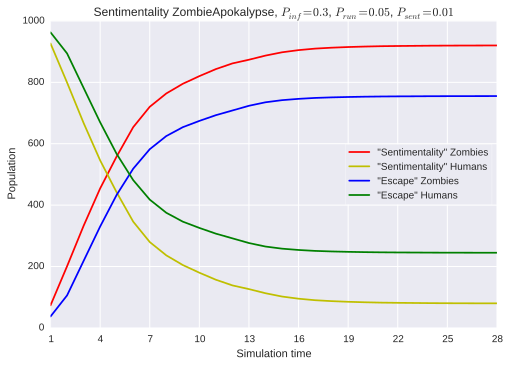

In [7]:
zombies = census_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_03').T
humans = census_to_df(BaseLoggingAgent, 100, 0, dir_path='sim_03').T

plt.plot(zombies.mean(), color='r')
plt.plot(humans.mean(), color='y')


plt.plot(mean_escape_zombies, color='b')
plt.plot(mean_escape_humans, color='g')

plt.title('Sentimentality ZombieApokalypse, $P_{inf} = 0.3$, $P_{run} = 0.05$, $P_{sent} = 0.01$')
plt.legend(['"Sentimentality" Zombies', '"Sentimentality" Humans', 
            '"Escape" Zombies', '"Escape" Humans'], 
           loc=7, frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Population')
plt.xlabel('Simulation time');

# Stigmatization

This scenario tries to capture the theme of “leaving the dead weight behind”. Among the many morally disturbing questions protagonists in a zombie apocalypse have to face, this is the one that most clearly shows the eroding of morality in a post-zombie society. Essentially, this trope consists of leaving a person or a group of persons behind, because they are clearly marked as “zombie snack” from the beginning and would only serve to slow the others down. In some ways, this can be thought of as the corollary to the Sentimentality scenario. Albeit in a more pre-emptive sense, because, under the assumption of the Stigmatization strategy, people who are the most vulnerable to attack are left behind.

## Defining the agents behavior

In [69]:
class ZombieStigma(BaseNetworkAgent):
    def __init__(self, environment=None, agent_id=0, state=()):
        super().__init__(environment=environment, agent_id=agent_id, state=state)
        
        self.inf_prob = 0.3
        self.run_prob = 0.05
        self.sent_coef = 0
        self.stigma_coef = 0.02

    def run(self):
        while True:
            if self.state['id'] == 0:
                self.check_for_sentimentality()
                self.stigmatize()
                self.check_for_infection()
                self.count_friends()
                yield self.env.timeout(1)
            else:
                yield self.env.event()

    def stigmatize(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        for neighbor in human_neighbors:
            sorrounding_zombies = neighbor.get_neighboring_agents(state_id=1)
            if random.random() < (len(sorrounding_zombies) * self.stigma_coef):
                self.global_topology.remove_edge(self.id, neighbor.id)
                print('Stigmatize:', self.env.now, 'Edge:', self.id, neighbor.id, sep='\t')
                
    def check_for_infection(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        for neighbor in zombie_neighbors:
            if random.random() < self.inf_prob:
                self.state['id'] = 1 # zombie
                print('Infection:', self.env.now, self.id, '<--', neighbor.id, sep='\t')
                break
                
    def check_for_sentimentality(self):
        zombie_neighbors = self.get_neighboring_agents(state_id=1)
        sent_prob = self.run_prob - (self.env.now * self.sent_coef)
        for neighbor in zombie_neighbors:
            if random.random() < sent_prob:
                self.global_topology.remove_edge(self.id, neighbor.id)
                print('Rejection:', self.env.now, 'Edge:', self.id, neighbor.id, sep='\t')

    def count_friends(self):
        human_neighbors = self.get_neighboring_agents(state_id=0)
        self.state['friends'] = len(human_neighbors)

## Executing the simulation

In [72]:
%%capture capt_log_sim2

# Starting out with a human population
init_states = [{'id': 0, } for _ in range(number_of_nodes)]

# Randomly seeding patient zero
patient_zero = random.randint(0, number_of_nodes)
init_states[patient_zero] = {'id': 1}

# Setting up the simulation
sim = NetworkSimulation(topology=G, states=init_states, agent_type=ZombieStigma, 
                        max_time=28, num_trials=100, logging_interval=1.0, dir_path='sim_04')

# Running the simulation
sim.run_simulation()

## Plotting the results

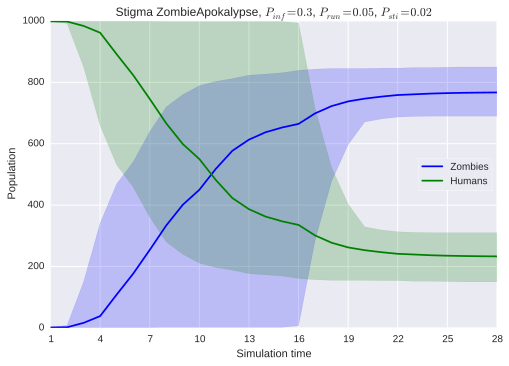

In [8]:
zombies = census_to_df(BaseLoggingAgent, 10, 1, dir_path='sim_04').T
humans = census_to_df(BaseLoggingAgent, 10, 0, dir_path='sim_04').T

plt.plot(zombies.mean(), color='b')
plt.fill_between(zombies.columns, zombies.max(), zombies.min(), color='b', alpha=.2)

plt.plot(humans.mean(), color='g')
plt.fill_between(humans.columns, humans.max(), humans.min(), color='g', alpha=.2)

plt.title('Stigma ZombieApokalypse, $P_{inf} = 0.3$, $P_{run} = 0.05$, $P_{sti}=0.02$')
plt.legend(['Zombies', 'Humans'], loc=7, frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Population')
plt.xlabel('Simulation time');

# Changes in network parameters over time

## Edge count

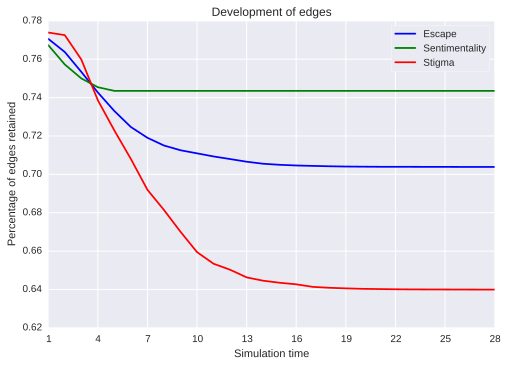

In [12]:
escape_ec_df = edge_count_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_02').T / float(len(G.edges()))
sentimentality_ec_df = edge_count_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_03').T / float(len(G.edges()))
stigma_ec_df = edge_count_to_df(BaseLoggingAgent, 100, 1, dir_path='sim_04').T / float(len(G.edges()))

plt.plot(escape_ec_df.mean(), color='b')
plt.plot(sentimentality_ec_df.mean(), color='g')
plt.plot(stigma_ec_df.mean(), color='r')

plt.title('Development of edges')
plt.legend(['Escape', 'Sentimentality', 'Stigma'], loc='best', frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Percentage of edges retained')
plt.xlabel('Simulation time');

## "Friends" retained

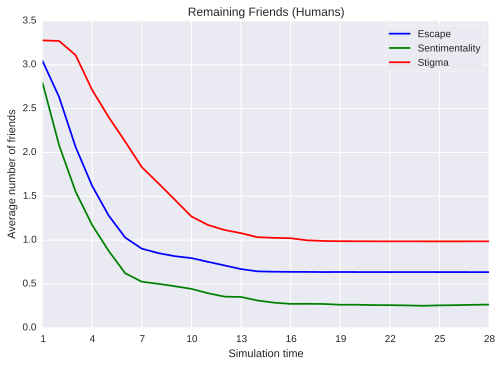

In [14]:
escape_friends = friends_to_the_end(BaseLoggingAgent, 100, dir_path='sim_02').T
sentimentality_friends = friends_to_the_end(BaseLoggingAgent, 100, dir_path='sim_03').T
stigma_friends = friends_to_the_end(BaseLoggingAgent, 100, dir_path='sim_04').T

plt.plot(escape_friends.mean(), color='b')
plt.plot(sentimentality_friends.mean(), color='g')
plt.plot(stigma_friends.mean(), color='r')

plt.title('Remaining Friends (Humans)')
plt.legend(['Escape', 'Sentimentality', 'Stigma'], loc='best', frameon=True)
plt.xlim(xmax=27)
plt.xticks(np.arange(0, 28., 3), tuple(range(1, 29, 3)))
plt.ylabel('Average number of friends')
plt.xlabel('Simulation time');